# EJERCICIO 1

Desarrollar un método computacional que, a partir de una imagen aérea, permita:
Segmentar las carreteras existentes en la imagen. Es decir, dada una imagen aérea, propor-
cionar una máscara binaria con los pı́xeles de carretera a 1 y el resto a 01 .
Proporcionar una evaluación cuantitativa de la segmentación usando el ground truth corres-
pondiente, usando una metodologı́a apropiada.

USAR MACHINE LEARNING -> PATERN RECOGNITION
    pipeline -> [extraccion de caracteristicas] -> NO seleccion de caracteristicas -> clasificacion

20 IMG
20 MASK

-------

SE ENTRENA CON LAS MASCARAS

    N-RANDOM O K-FOLD

TABLA PARA LA VALIDACION
    $\mu \pm \sigma$ 
- CLASIFICACION BINARIA PIXEL A PIXEL
    - CARRETA -> 1 | NO CARRETERA -> 0


buscar en librerias:
    baseline -> version mas simple
        vec de caracteristicas -> entra en el clasificador          -> salida mascara
                                            ^
                                            |
                                  otro vector de caracteristicas = mascara
    extractores de caracteristicas

vectores nxm con los 3 valores de los pixeles

aproximaciones:
    añadir caracteristicas -> aumenta el vector de caracteristicas
    

In [34]:
import os

# Imprime el directorio actual de trabajo
print("Directorio actual:", os.getcwd())

# Verifica si el directorio existe
ruta_base = "/home/clown/3-year/computer_vision/roads"
if os.path.exists(ruta_base):
    print("La ruta base existe")
else:
    print("La ruta base no existe")

Directorio actual: /home/clown/3-year/computer_vision/p3
La ruta base existe


In [35]:
import numpy as np
import skimage.io as io
import glob
import cv2

# Ruta a tus imágenes y máscaras
image_paths = glob.glob("/home/clown/3-year/computer_vision/roads/sat/*.tif*")
mask_paths = glob.glob("/home/clown/3-year/computer_vision/roads/gt/*.tif*")

# image_paths = glob.glob("/home/clown/3-year/computer_vision/p3/sat/*.tiff")
# mask_paths = glob.glob("/home/clown/3-year/computer_vision/p3/gt/*.tif")

# Cargar imágenes y máscaras
images = [io.imread(img_path) for img_path in image_paths]
masks = [io.imread(mask_path) for mask_path in mask_paths]

# Redimensionar
if len(images) > 0 and len(masks) > 0:
    images = [cv2.resize(img, (256, 256)) for img in images]
    masks = [cv2.resize(mask, (256, 256)) for mask in masks]
    print("Redimensionamiento completado.")
else:
    print("No se cargaron imágenes o máscaras.")


Redimensionamiento completado.


In [36]:

def extract_features(image):
    # Vector de características RGB
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    # Matriz de valores RGB para cada pixel
    rgb_features = np.stack((r.flatten(), g.flatten(), b.flatten()), axis=1)
    
    # Conversión a escala de grises y extracción de bordes con Canny
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 150, 300).flatten()

    # Concatenar RGB y bordes en un solo vector de características
    features = np.concatenate((rgb_features, edges[:, np.newaxis]), axis=1)
    return features

# Aplicar extracción de características a todas las imágenes
features = [extract_features(img) for img in images]



In [ ]:
HACER downsampling

In [41]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

# Aplanar las máscaras para obtener etiquetas (1 para carretera, 0 para no-carretera)
labels = [mask.flatten() for mask in masks]

# Inicialización del clasificador y k-fold cross-validation
kf = KFold(n_splits=8)
metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

for train_index, test_index in kf.split(features):
    X_train = np.vstack([features[i] for i in train_index])
    y_train = np.hstack([labels[i] for i in train_index])
    X_test = np.vstack([features[i] for i in test_index])
    y_test = np.hstack([labels[i] for i in test_index])
    
    # Entrenar clasificador
    # clf = RandomForestClassifier(n_estimators=50)
    clf = XGBClassifier(tree_method='gpu_hist')
    clf.fit(X_train, y_train)
    
    # Evaluación en conjunto de prueba
    y_pred = clf.predict(X_test)
    metrics["accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["precision"].append(precision_score(y_test, y_pred, average="macro"))
    metrics["recall"].append(recall_score(y_test, y_pred, average="macro"))
    metrics["f1"].append(f1_score(y_test, y_pred, average="macro"))

# Mostrar resultados de validación cruzada
for metric_name, scores in metrics.items():
    print(f"{metric_name.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

Accuracy: 0.9494 ± 0.0101
Precision: 0.0039 ± 0.0001
Recall: 0.0040 ± 0.0001
F1: 0.0039 ± 0.0001


/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


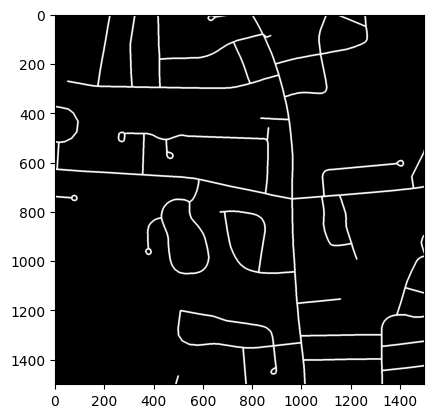

In [38]:
import matplotlib.pyplot as plt

new_image = io.imread("/home/clown/3-year/computer_vision/roads/gt/10228705_15.tif")
plt.imshow(new_image, cmap="gray")
plt.show()

SOBRE ENTRENAMIENTO
USAR COMO LABELS 
    FOTO BLANCA
    FOTO NEGRA



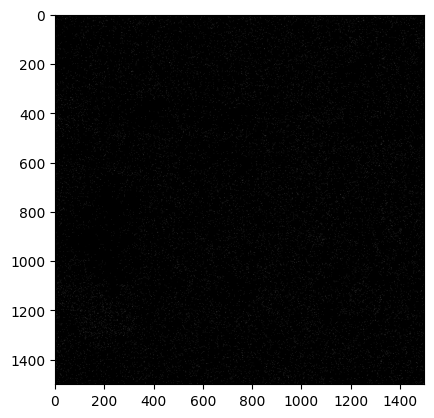

In [39]:
def predict_mask(image, model):
    features = extract_features(image)
    mask_pred = model.predict(features)
    return mask_pred.reshape(image.shape[:2])

# Generar máscara para una nueva imagen
new_image = io.imread("/home/clown/3-year/computer_vision/roads/sat/10228705_15.tiff")
mask_pred = predict_mask(new_image, clf)

# Mostrar la máscara predicha
import matplotlib.pyplot as plt
plt.imshow(mask_pred, cmap="gray")
plt.show()


In [40]:
# Comparar máscara predicha con ground truth
ground_truth = io.imread("/home/clown/3-year/computer_vision/p3/gt/10078675_15.tif")

accuracy = accuracy_score(ground_truth.flatten(), mask_pred.flatten())
precision = precision_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
recall = recall_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")
f1 = f1_score(ground_truth.flatten(), mask_pred.flatten(), average="macro")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/home/clown/3-year/computer_vision/Computer-Vision/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.9727
Precision: 0.0042
Recall: 0.0042
F1 Score: 0.0042


# EJERCICIO 2

Desarrollar un método computacional que, a partir de una imagen (y opcionalmente su máscara
de recorte), permita:
Identificar las imágenes que pertenecen a las categorı́as2 : “elephant” y “rhino”.
Proporcionar una evaluación cuantitativa adecuada de la identificaciones correspondientes

Es decir, clasificar cada imagen, considerando caracterı́sticas integradas para toda la imagen, región recortada y/o contorno, entre, por ejemplo, clase objetivo y resto